In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
from scipy import stats
import math

In [2]:
import os
print(os.getcwd())


C:\Users\장세환\Documents


In [3]:
os.chdir("E:/bigcontest")
print(os.getcwd())

E:\bigcontest


# 데이터 생성

In [4]:
train= pd.read_excel('./train_ver1.xlsx',header= 0)
train = train[train['판매단가'] < train['취급액']]

In [5]:
train['노출(분)'] = train['노출(분)'].replace(0, math.nan)
train['노출(분)'] = train['노출(분)'].fillna(method='ffill')

In [6]:
train.index = np.arange(7513)

In [7]:
test = pd.read_excel('./test_ver1.xlsx',header= 0)

In [8]:
data = pd.read_excel('./2020_bigcontest_champion_performance.xlsx', header=1)
data = data[data['상품군']!='무형'] 
data = data[data['판매단가'] < data['취급액']]
data['날짜'] = pd.to_datetime(data['방송일시']).dt.date
data['날짜'] = pd.to_datetime(data['날짜'])
data['주문량'] = data['취급액']/data['판매단가']
data["요일"]=data["방송일시"].dt.dayofweek # 요일
data["시"]=data["방송일시"].dt.hour # 시
data['월'] = data['방송일시'].dt.month # 월
weekday = {"월":0,"화":1,"수":2,"목":3,"금":4,"토":5,"일":6}

In [9]:
data = data.fillna(method='ffill')

In [10]:
data = data.iloc[17604:25792]

# 날씨 처리

In [11]:
# 대표 지역들
places = ["강릉","광주","부산","수원","울산","대구","대전","서울","파주"] 
weather = pd.read_excel("/content/drive/My Drive/빅콘폴더/날씨_실제/강릉날씨.xlsx")
row_num = weather.shape[0]
weather["지역"]=["강릉"]*row_num

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/빅콘폴더/날씨_실제/강릉날씨.xlsx'

In [ ]:
# 모든 지역 날씨 데이터 세로로 합치기
for p in places[1:]:
    a=pd.read_excel(f"/content/drive/My Drive/빅콘폴더/날씨_실제/{p}날씨.xlsx")
    a["지역"]=[p]*row_num
    weather = pd.concat([weather, a], axis=0)

In [ ]:
# "-" -> 0값으로 변경
weather["강수량(mm)"]=weather["강수량(mm)"].replace("-",0)
weather["신적설(cm)"]=weather["신적설(cm)"].replace("-",0)
weather["운량(1/10)"]=weather["운량(1/10)"].replace("-",0)

# object 형 float 형으로 변경
weather["강수량(mm)"]=weather["강수량(mm)"].astype(float)
weather["신적설(cm)"]=weather["신적설(cm)"].astype(float)
weather["운량(1/10)"]=weather["운량(1/10)"].astype(float)

In [ ]:
weather = weather.reset_index()

In [ ]:
# 날짜 set 맞추기
new_weather = pd.DataFrame()
new_weather = weather.iloc[165:243]
new_weather = pd.concat([new_weather, weather.iloc[753:831]])
new_weather = pd.concat([new_weather, weather.iloc[1341:1419]])
new_weather = pd.concat([new_weather, weather.iloc[1929:2007]])
new_weather = pd.concat([new_weather, weather.iloc[2517:2595]])
new_weather = pd.concat([new_weather, weather.iloc[3105:3183]])
new_weather = pd.concat([new_weather, weather.iloc[3693:3771]])
new_weather = pd.concat([new_weather, weather.iloc[4281:4359]])
new_weather = pd.concat([new_weather, weather.iloc[4869:4947]])

In [ ]:
# 서울 날씨와 강릉, 부산 날씨로 칼럼별 주문량 상관성 확인 및 지역별 날씨의 영향도 확인
gang_weather = new_weather.loc[new_weather["지역"]=="강릉",:]
seoul_weather = new_weather.loc[new_weather["지역"]=="서울",:]
busan_weather = new_weather.loc[new_weather["지역"]=="부산",:]
suwon_weather = new_weather.loc[new_weather["지역"]=="수원",:]
sudogwon_weather = new_weather.loc[(new_weather["지역"]=="서울")|(weather["지역"]=="수원"),:]

In [ ]:
day_data = data.copy()

In [ ]:
day_data['날짜'] = pd.to_datetime(day_data['날짜'])
new_weather['날짜'] = pd.to_datetime(new_weather['날짜'])

In [ ]:
all_data = day_data.merge(new_weather, on='날짜')
all_data = all_data.groupby(['날짜']).mean()

In [ ]:
sudogwon_weather['날짜'] = pd.to_datetime(sudogwon_weather['날짜'] )
seoul_weather['날짜'] = pd.to_datetime(seoul_weather['날짜'] )
busan_weather['날짜'] =pd.to_datetime(busan_weather['날짜'] )
suwon_weather['날짜'] = pd.to_datetime(suwon_weather['날짜'] )
gang_weather['날짜'] = pd.to_datetime(gang_weather['날짜'])

In [ ]:
sudogwon_data = day_data.merge(sudogwon_weather, on="날짜")
suwon_data = day_data.merge(suwon_weather, on="날짜")
seoul_data = day_data.merge(seoul_weather, on="날짜")
busan_data = day_data.merge(busan_weather, on="날짜")
gang_data = day_data.merge(gang_weather, on="날짜")

In [ ]:
fc_prop = pd.read_csv("/content/drive/My Drive/빅콘폴더/날씨예보/서울날씨/강수확률.csv")
fc_amount = pd.read_csv("/content/drive/My Drive/빅콘폴더/날씨예보/서울날씨/6시간 강수량.csv") 
fc_sky = pd.read_csv("/content/drive/My Drive/빅콘폴더/날씨예보/서울날씨/하늘상태.csv")
fc_top = pd.read_csv("/content/drive/My Drive/빅콘폴더/날씨예보/서울날씨/일최고기온.csv")
fc_bottom = pd.read_csv("/content/drive/My Drive/빅콘폴더/날씨예보/서울날씨/일최저기온.csv")

In [ ]:
forecast_data = {"강수확률":fc_prop, "강수량":fc_amount,"하늘상태":fc_sky, "일최고기온":fc_top, "일최저기온":fc_bottom}

In [ ]:
forecast = pd.DataFrame()

for name, fcdata in forecast_data.items():
    amount_list=[]
    cycle = (fcdata.shape[0])//365 # 하루 관측량
    for i in range(365):
        day_weather = fcdata.iloc[i*cycle:(i+1)*cycle,-1].mean()
        amount_list.append(day_weather)
    forecast[name]=amount_list

In [ ]:
forecast = forecast.iloc[165:243]

In [ ]:
# 날짜 칼럼 추가
forecast["날짜"]=train["날짜"].unique()

# 마더코드, 일/월별 처리

In [12]:
def hand_by_momcode(data):
  momcodegroup = data.groupby(['마더코드']).sum()
  momcodegroup['주문량/노출'] = momcodegroup['주문량']/momcodegroup['노출(분)']
  topcode = list(momcodegroup.sort_values('주문량/노출', ascending=False).index[:50]) #탑50개
  return topcode

In [13]:
hand_by_momcode(train) # train으로 topcode생성

[100492,
 100499,
 100046,
 100754,
 100323,
 100253,
 100844,
 100523,
 100019,
 100167,
 100841,
 100452,
 100026,
 100829,
 100818,
 100777,
 100021,
 100322,
 100511,
 100416,
 100822,
 100172,
 100455,
 100348,
 100589,
 100166,
 100165,
 100074,
 100197,
 100403,
 100327,
 100281,
 100460,
 100015,
 100588,
 100169,
 100318,
 100755,
 100275,
 100010,
 100479,
 100202,
 100612,
 100009,
 100319,
 100773,
 100747,
 100171,
 100109,
 100849]

- 상품군내 마더코드별 주문량

In [14]:
multi_grouped = train.groupby(['상품군','마더코드'])
MultiGroup = multi_grouped['주문량'].sum()
MultiGroup = MultiGroup.reset_index()

In [15]:
item = list(set(MultiGroup['상품군']))

C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47560 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 45908 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 53076 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 46300 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 47560 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 45908 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Anaconda\lib\site-packages\ma

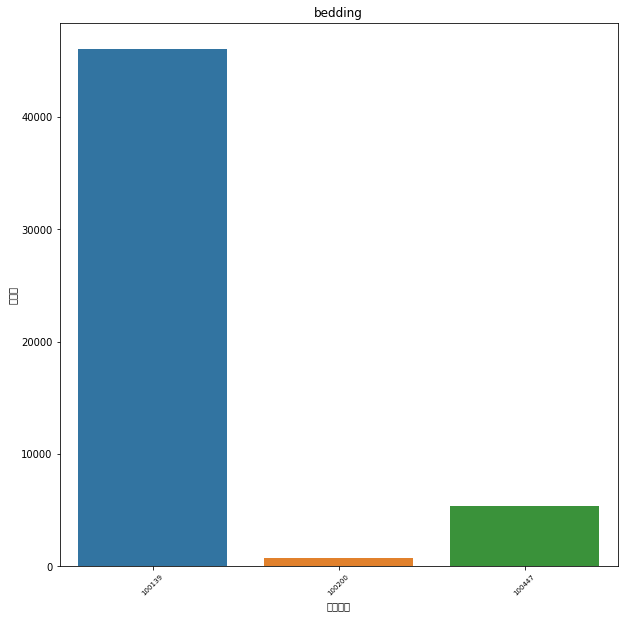

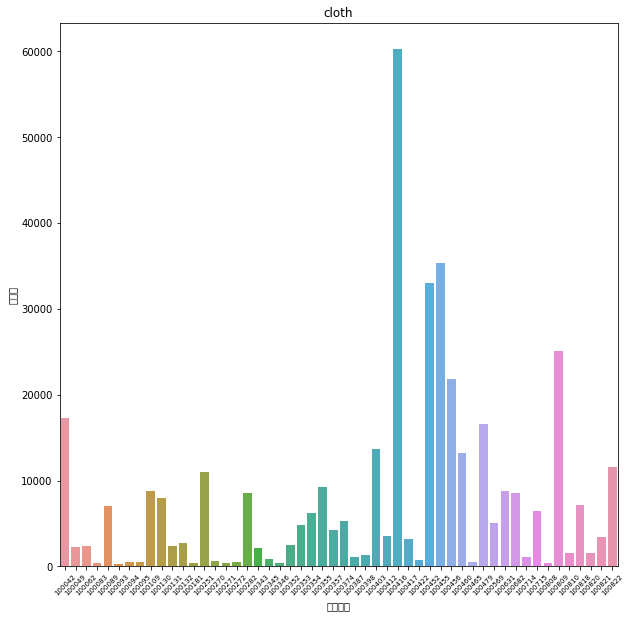

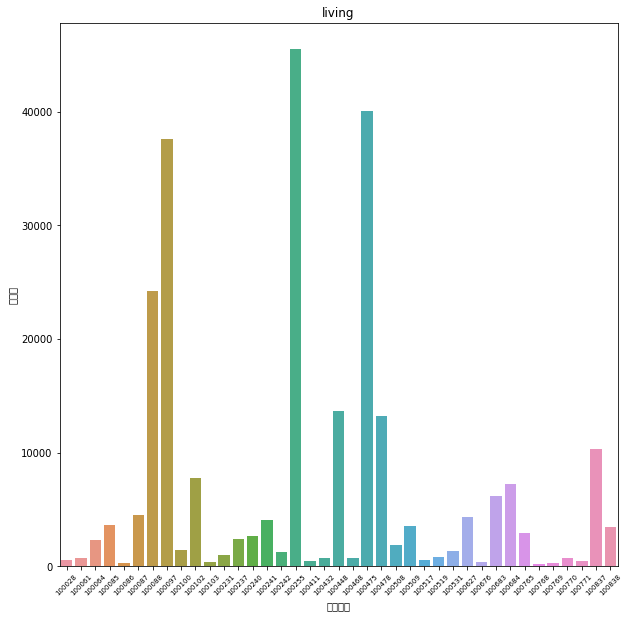

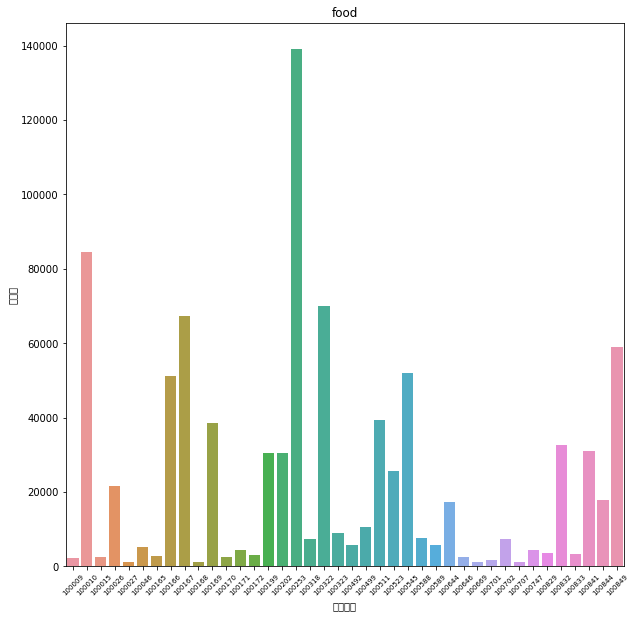

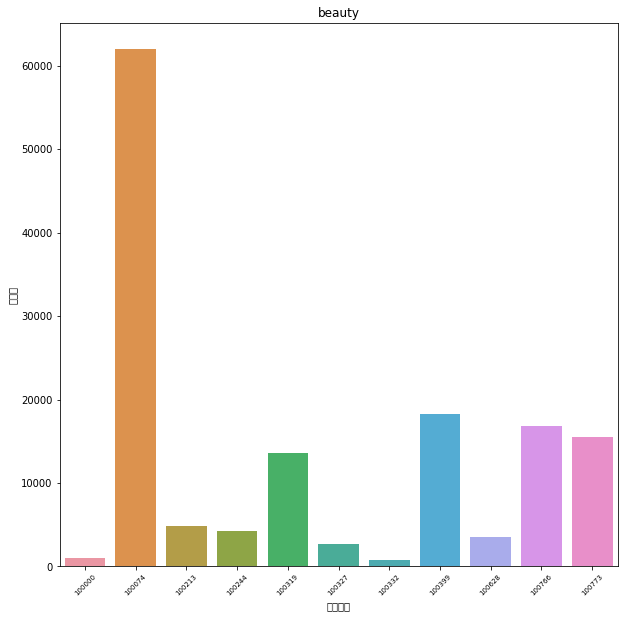

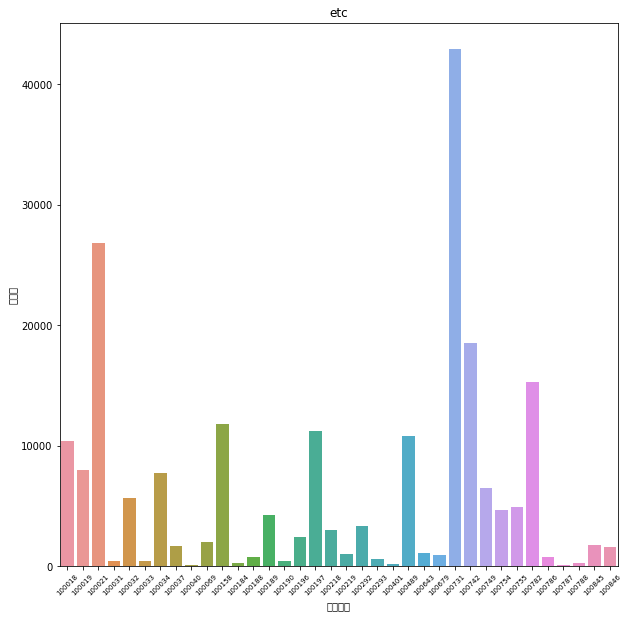

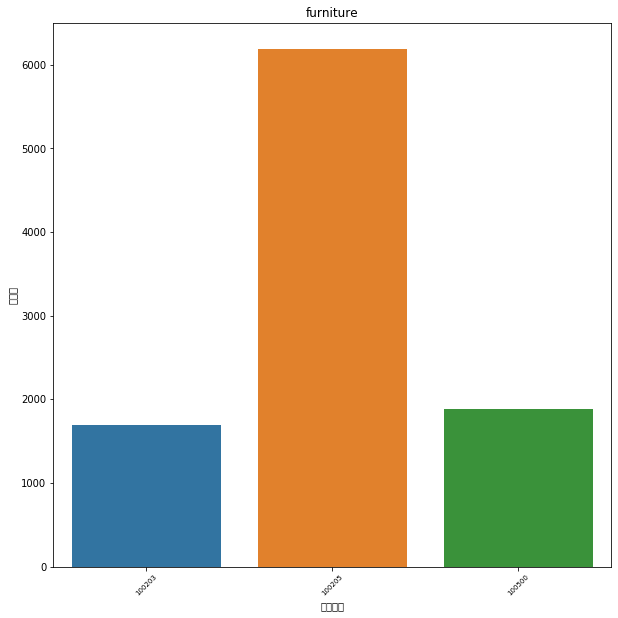

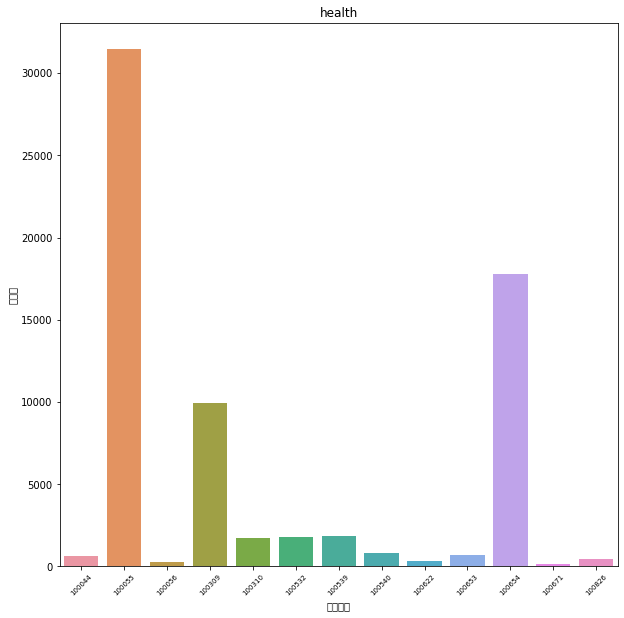

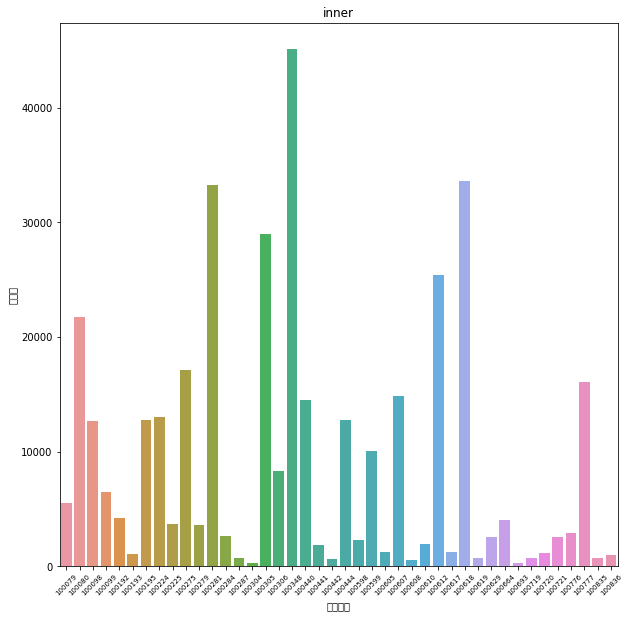

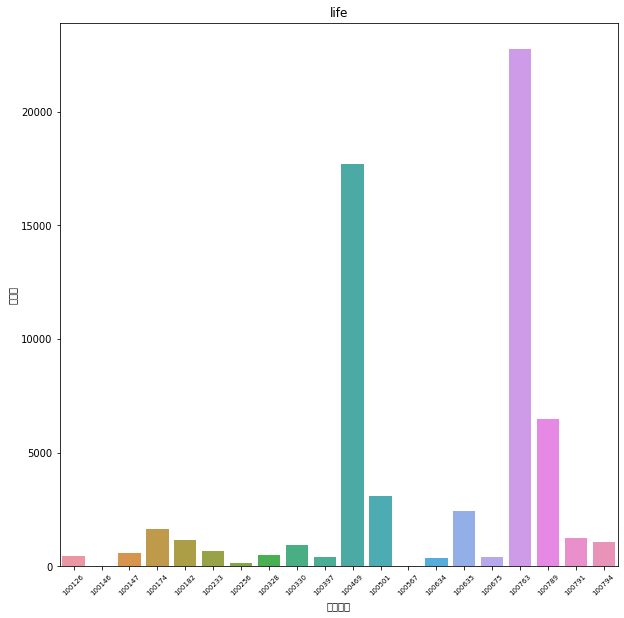

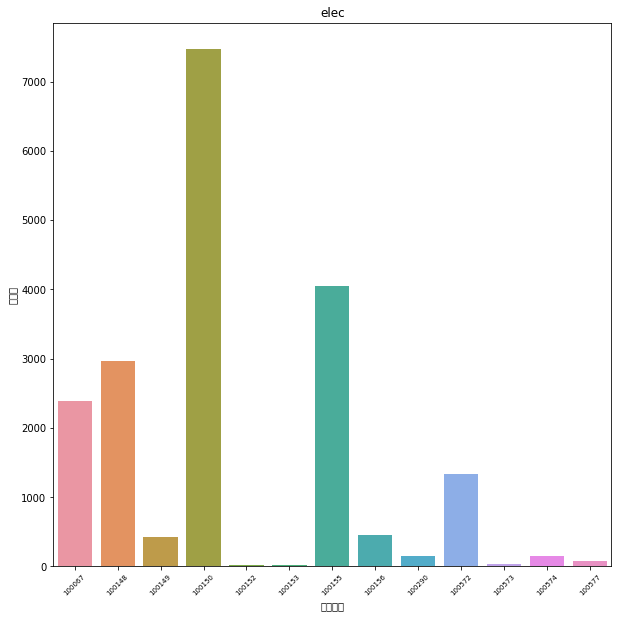

In [16]:
for i in item:
    plt.figure(figsize=(10,10))
    sns.barplot(data=MultiGroup[MultiGroup['상품군']==i], x='마더코드', y='주문량')
    plt.title(i)
    plt.xticks(rotation=45, size=7)

- 시간대 상품군별 주문량

In [17]:
hour_grouped = train.groupby(['시','상품군'])
HourGroup = hour_grouped['주문량'].sum()
HourGroup = HourGroup.reset_index()

C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:176: RuntimeWarning: Glyph 49884 missing from current font.
  font.load_char(ord(s), flags=flags)
C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47928 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Anaconda\lib\site-packages

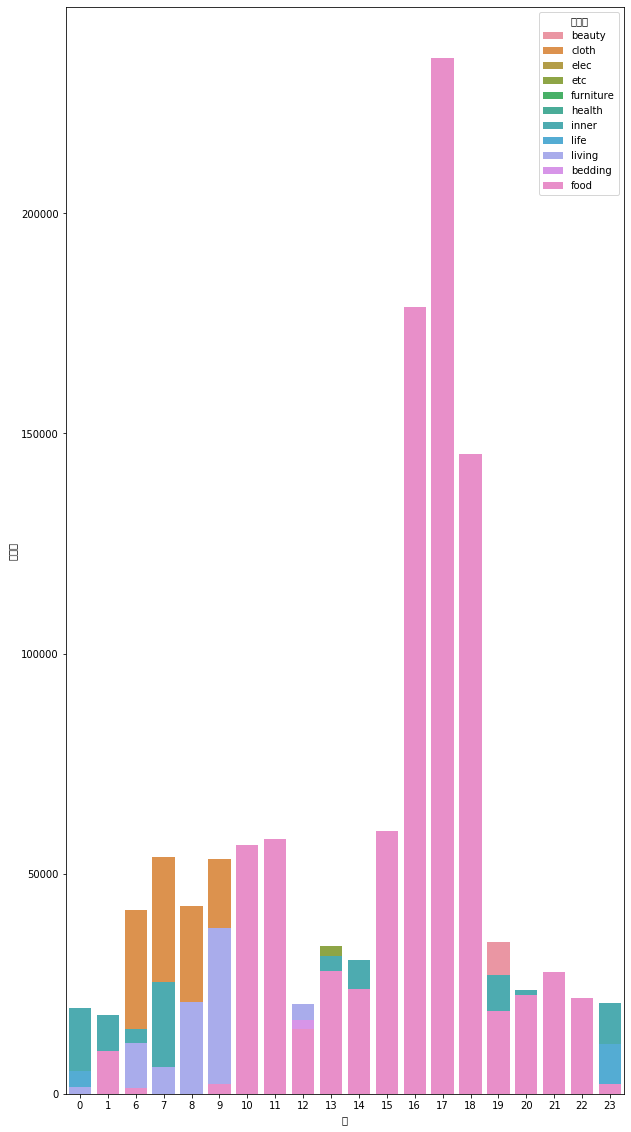

In [18]:
plt.figure(figsize=(10,20))
sns.barplot(data=HourGroup, x='시', y='주문량', hue='상품군', dodge=False)

In [19]:
train['new판매단가'] = np.log(train['판매단가'])
train.drop('판매단가', inplace=True, axis=1)

In [20]:
np.corrcoef(train['주문량'],train['new판매단가'])

array([[ 1.        , -0.61081947],
       [-0.61081947,  1.        ]])

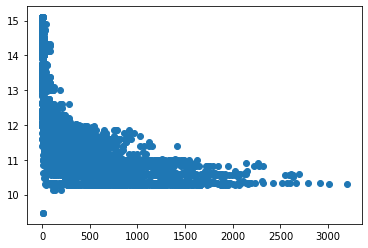

In [21]:
plt.scatter(train['주문량'], (train['new판매단가'])) 

C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47928 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 47928 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0, flags=flags)


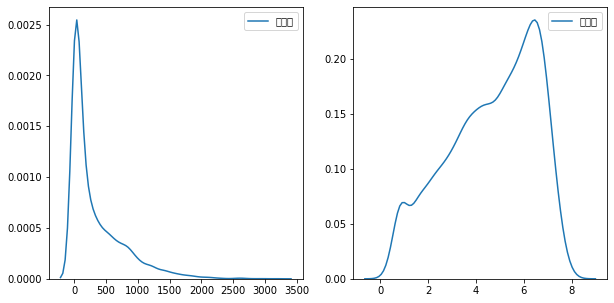

In [22]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.kdeplot(train['주문량'], ax=ax[0]) #커널 밀도추정
sns.kdeplot(np.log(train['주문량']), ax=ax[1])

In [23]:
train['new주문량'] = np.log(train['주문량'])
train.drop('주문량', inplace=True, axis=1)

# 모델학습 데이터 생성 및 분리

- 시간대

In [24]:
time = train.groupby('HOUR').aggregate(np.mean)

time_rank = {}
rank = 1 
for idx, row in time.sort_values(by='new주문량').iterrows():
    time_rank[idx] = rank
    rank += 1

In [25]:
prime_time = []

for idx, row in train.iterrows():
    prime_time.append(time_rank[row.HOUR])
    
train['prime_time'] = prime_time

- 요일

In [26]:
day = train.groupby('요일').aggregate(np.mean)

day_rank = {}
rank = 1 
for idx, row in day.sort_values(by='new주문량').iterrows():
    day_rank[idx] = rank
    rank += 1
    
prime_day = []

for idx, row in train.iterrows():
    prime_day.append(day_rank[row.요일])
    
train['prime_day'] = prime_day

- 요일

In [37]:
intercode = set(test['마더코드'].unique()).intersection(set(train['마더코드'].unique()))
interitem = train[train['마더코드'].isin(intercode)]

KeyError: '마더코드'

- test랑 겹치는 마더코드

In [38]:
code = interitem.groupby('마더코드').aggregate(np.mean)

code_rank = {}
rank = 1
for idx, row in code.sort_values(by='new주문량').iterrows():
    code_rank[idx] = rank
    rank += 1

top_code = []

for idx, row in train.iterrows():
    if row.마더코드 in code_rank.keys():
        top_code.append(code_rank[row.마더코드])
    else:
        top_code.append(0)
        
train['top_code'] = top_code

NameError: name 'interitem' is not defined

- 분류기준 top_분류

In [39]:
cat = train.groupby('분류').aggregate(np.mean)

cat_rank = {}
rank = 1
for idx, row in cat.sort_values(by='new주문량').iterrows():
    cat_rank[idx] = rank
    rank += 1

top_cat = []

for idx, row in train.iterrows():
    top_cat.append(cat_rank[row.분류])
    
train['top_cat'] = top_cat

- 성은님코드 : 분류원핫+pca
- 회선 : 빈도수인코딩

In [30]:
# 원핫+PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

In [31]:
enc1 = OneHotEncoder()
category = np.array(train['분류'])
category = category.reshape(-1, 1)

In [32]:
enc1.fit(category)
category_ = enc1.transform(category).toarray()

In [33]:
pca = PCA(n_components=2)
res = pca.fit_transform(category_)
res = pd.DataFrame(res, columns=['x1_cat','x2_cat'])

ValueError: array must not contain infs or NaNs

In [35]:
train['x1_cat'] = res['x1_cat']
train['x2_cat'] = res['x2_cat']

NameError: name 'res' is not defined

In [34]:
train['x1_cat']

KeyError: 'x1_cat'

- 실제날씨(서울)

In [40]:
real = train.groupby('실제_서울_날씨').aggregate(np.mean)

real_rank = {}
rank = 1
for idx, row in real.sort_values(by='new주문량').iterrows():
    real_rank[idx] = rank
    rank += 1

top_real_weather = []

for idx, row in train.iterrows():
    top_real_weather.append(real_rank[row.실제_서울_날씨])
    
train['top_real_weather'] = top_real_weather

-실제날씨 통합

In [ ]:
real_total_weather = pd.read_excel('/content/drive/My Drive/빅콘폴더/날씨_실제/날씨통합.xlsx')
real_total_weather

In [ ]:
train['실제_최고기온'] = real_total_weather['최고기온']
train['실제_최저기온'] = real_total_weather['최저기온']
train['실제_강수량'] = real_total_weather['강수량']
train['실제_평균풍속'] = real_total_weather['평균풍속']

In [ ]:
train

In [ ]:
#corr_mat = train.corr()
#corr_mat['new주문량'].sort_values(ascending=False)

In [ ]:
# train.drop(['Unnamed: 0', '방송일시', '상품명', '상품군', 'holiday', '요일', 'HOUR', '마더코드'], inplace=True, axis=1)
# 방송일시, 상품명, 상품군, holiday(주말), 요일, HOUR, 마더코드

# Feature Engineering & 인코딩

In [ ]:
# 빈도수인코딩(위의 원핫+pca와 비교해보기)
def add_frequency_encoding(data,column): #데이터프레임,열을 받아서 빈도수인코딩열을 추가해줌
  enc_nom = (data.groupby(column).size())/len(data)
  data['freq_encode_{}'.format(column)] = data[column].apply(lambda x:enc_nom[x])
  print("freq_encode column was added")

In [ ]:
add_frequency_encoding(train,'분류')

# 모델 생성 및 학습

- train, test split

In [41]:
'''
# 통째로 split할경우 실행

from sklearn.model_selection import train_test_split

total_x = train.drop('new주문량', axis=1)
total_y = train['new주문량']

total_x_train, total_x_val, total_y_train, total_y_val = train_test_split(x, y, test_size=0.33, random_state=1234)
'''

"\n# 통째로 split할경우 실행\n\nfrom sklearn.model_selection import train_test_split\n\ntotal_x = train.drop('new주문량', axis=1)\ntotal_y = train['new주문량']\n\ntotal_x_train, total_x_val, total_y_train, total_y_val = train_test_split(x, y, test_size=0.33, random_state=1234)\n"

In [42]:
#모든 카테고리에 대해 따로따로 자동 변수생성
category_list = train['상품군'].unique().tolist()
for i in category_list:
  globals()['x_{}'.format(i)] = train.loc[train['상품군']==i] #카테고리에 해당하는 주문량제외 train데이터 할당
  globals()['y_{}'.format(i)] = train['new주문량'].loc[train['상품군']==i] #카테고리에 해당하는 train의 주문량을 할당

In [43]:
for i in range(11):
  print('x_{}'.format(category_list[i])) #11개 상품군 다 성공적으로 변수 생성됨.

x_inner
x_cloth
x_elec
x_living
x_food
x_health
x_bedding
x_furniture
x_beauty
x_etc
x_life


In [44]:
#카테고리별로 x,y를 train test 스플릿해줌.
from sklearn.model_selection import train_test_split
for i in category_list:
  x_for_split = globals()['x_{}'.format(i)]
  y_for_split = globals()['y_{}'.format(i)]
  globals()['x_train_{}'.format(i)], globals()['x_test_{}'.format(i)], globals()['y_train_{}'.format(i)], globals()['y_test_{}'.format(i)] = train_test_split(x_for_split, y_for_split, test_size=0.33, random_state=1234)
# 카테고리별로 X_train_카테고리 , X_test_카테고리, Y_train_카테고리, Y_test_카테고리 생성됐음.

In [45]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=1234)

In [46]:
seungen_feature = ['노출(분)', 'holiday(includeSS)','실제_최고기온','실제_최저기온','실제_강수량','실제_평균풍속' , '예보_서울_강수확률', '예보_서울_강수량',
       '예보_서울_하늘상태', '예보_서울_일최고기온', '예보_서울_일최저기온', '예보_일산_강수확률', '예보_일산_강수량',
       '예보_일산_일최고기온', '예보_일산_일최저기온', '예보_수원_강수확률', '예보_수원_강수량', '예보_수원_일최고기온',
       '예보_수원_일최저기온', 'Active Users', 'new판매단가', 'prime_time',
       'prime_day', 'top_code', 'top_cat']

In [47]:
feature_selection = x_train_beauty.loc[:,seungen_feature].columns.values
feature_selection

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

In [ ]:
for i in category_list:
  globals()['shop_train_x_{}'.format(i)] = globals()['x_train_{}'.format(i)][feature_selection]
  globals()['shop_test_x_{}'.format(i)] = globals()['x_test_{}'.format(i)][feature_selection]

# 6번. 카테고리별 20분단위로 3갈해서 각각 피팅


In [48]:
Imsi_list = x_beauty.groupby(['마더코드','날짜']).count()['노출(분)'] #마더코드별로 방송 노출분
Imsi_list

마더코드    날짜        
100000  2019-08-26    3
        2019-08-30    3
100074  2019-06-18    3
        2019-06-24    3
        2019-06-25    3
                     ..
100773  2019-07-06    3
        2019-07-15    3
        2019-07-19    3
        2019-07-26    3
        2019-07-29    3
Name: 노출(분), Length: 71, dtype: int64

In [49]:
Imsi_list #첫번쨰 상품에 대한 노출분

마더코드    날짜        
100000  2019-08-26    3
        2019-08-30    3
100074  2019-06-18    3
        2019-06-24    3
        2019-06-25    3
                     ..
100773  2019-07-06    3
        2019-07-15    3
        2019-07-19    3
        2019-07-26    3
        2019-07-29    3
Name: 노출(분), Length: 71, dtype: int64

In [50]:
hallo = train.groupby(['마더코드','날짜']).count()['노출(분)'] 
len(hallo[hallo==6]),len(hallo[hallo==5]),len(hallo[hallo==4]),len(hallo[hallo==3]),len(hallo[hallo==2]),len(hallo[hallo==1])

(279, 13, 29, 815, 89, 14)

In [51]:
Imsi_df = x_beauty[x_beauty['마더코드']==Imsi_list.index[0]]
Imsi_df

,Unnamed: 0,방송일시,노출(분),마더코드,상품코드,상품명,상품군,취급액,날짜,시간,...,MONTH,HOUR,DAY,Active Users,new판매단가,new주문량,prime_time,prime_day,top_cat,top_real_weather


In [52]:
for i in range(len(Imsi_list)):
  Imsi_df = pd.DataFrame()
  Imsi_df = x_beauty[x_beauty['마더코드']==Imsi_list.index.unique()[i]]


In [53]:
new_x_beauty = pd.DataFrame()
for i in range(len(Imsi_df)):
  count = 0
  if(count<x_beauty.groupby(['마더코드','날짜'])['노출(분)'].count().iloc[1]):
    new_x_beauty = new_x_beauty.append(Imsi_df.iloc[i])
    count+=1

In [54]:
new_x_beauty

""


In [55]:
x_beauty.groupby(['마더코드','날짜'])['노출(분)'].count()

마더코드    날짜        
100000  2019-08-26    3
        2019-08-30    3
100074  2019-06-18    3
        2019-06-24    3
        2019-06-25    3
                     ..
100773  2019-07-06    3
        2019-07-15    3
        2019-07-19    3
        2019-07-26    3
        2019-07-29    3
Name: 노출(분), Length: 71, dtype: int64

In [59]:
x_beauty['분류']

214      h3
215      h3
334     h11
335     h11
363     h14
       ... 
7406    h14
7407    h14
7421     h9
7422     h9
7423     h9
Name: 분류, Length: 216, dtype: object

In [65]:
x_beauty=x_beauty.reset_index(drop=True)

In [82]:
x=x_beauty

In [83]:
x.loc[[1],'분류']

1    h3
Name: 분류, dtype: object

In [85]:
a=x.loc[[0],'분류']
a

0    h3
Name: 분류, dtype: object

In [96]:
if(a.tolist()[0]==x.loc[[i],'분류'].tolist()[0]):
    print('hello')

hello


In [97]:
train_total=[]
for i in range(8):
    train_total.append(x_beauty.head(0))
    
a=x_beauty.loc[[0],'분류']     
b=[x_beauty.loc[[0],:]]

for i in range(1, len(x_beauty)):
    if(a.tolist()[0] != x_beauty.loc[[i],'분류'].tolist()[0]):
        train_total[len(b)-1] = pd.concat(train_total[len(b)-1], b)
        b =[]
        a = x_beauty.loc[[i], '분류']
    b.append(x_beauty.loc[[i], :])

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

- 다중공선성 확인하기

In [ ]:
hi_feature = ['노출(분)', 'holiday(includeSS)','실제_최고기온','실제_최저기온','실제_강수량','실제_평균풍속' , '예보_서울_강수확률', '예보_서울_강수량', 'Active Users', 'new판매단가', 'prime_time',
       'prime_day', 'top_code', 'top_cat']
#실제날씨만 남겨놓은 Feature군

In [ ]:
mung = shop_train_x_beauty[hi_feature]
mung

In [ ]:
mung.corr()

In [ ]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
shop_train_x_corr = mung.corr()

In [ ]:
plt.rcParams['figure.figsize']=(15,10)

sns.heatmap(shop_train_x_corr.corr(),
          annot=True,
          cmap='Reds',
          vmin = -1, vmax = 1
          )

In [ ]:
# 피처마다의 VIF 계수를 출력
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(shop_train_x_corr.values, i) for i in range(shop_train_x_corr.shape[1])]
vif["features"] = shop_train_x_corr.columns
vif # 기존 feature_selection대로하면 다 엄청 높게나옴 +e3...이런식

- 랜포돌리기

In [ ]:
forest.fit(shop_train_x_beauty, y_train_beauty)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
predictions = forest.predict(shop_train_x_beauty)
mape = mean_absolute_percentage_error(y_train_beauty, predictions)
mape

In [ ]:
some_data = x_train_beauty.iloc[:8] # 8개의 Data의 주문량 예측해 보겠음.
some_labels = y_train_beauty.iloc[:8]
some_data = some_data[feature_selection]
print("예측", forest.predict(some_data))
print("레이블:", list(some_labels))

#모든 카테고리 반복문으로 한번에 fit & predict 결과

In [ ]:
mape_score = []
for i in category_list:
  category_data = globals()['shop_train_x_{}'.format(i)]
  category_label =  globals()['y_train_{}'.format(i)]
  forest.fit(category_data,category_label)
  predictions = forest.predict(category_data)
  mape_score.append(mean_absolute_percentage_error(category_label, predictions))

In [ ]:
for i in range(len(category_list)):
  print("RF MAPE score of",category_list[i],":",mape_score[i])

In [ ]:
pd.Series(mape_score).mean() # train자체적으로 해본성능 (validation 전체 기간 67%에 대해)

- test 셋으로 점수 확인해보기(33%)

In [ ]:
mape_score = []
for i in category_list:
  category_data = globals()['shop_train_x_{}'.format(i)]
  category_label =  globals()['y_train_{}'.format(i)]
  forest.fit(category_data,category_label) # train데이터로 fitting 되어잇음.
  test_data = globals()['shop_test_x_{}'.format(i)]
  test_label =  globals()['y_test_{}'.format(i)]
  predictions = forest.predict(test_data) 
  mape_score.append(mean_absolute_percentage_error(test_label, predictions))

In [ ]:
for i in range(len(category_list)):
  print("RF MAPE score of test",category_list[i],":",mape_score[i])

# 특성중요도 시각화

In [ ]:
print("특성 중요도:\n{}".format(forest.feature_importances_))

def plot_feature_importances_NS(view_data,model):
    n_features = view_data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), view_data.columns.tolist())
    plt.xlabel("특성 중요도")
    plt.ylabel("특성")
    plt.ylim(-1, n_features)

plot_feature_importances_NS(shop_train_x_life,forest) #다들 top_cat가 가장 유효하게 작용한것 같다.

In [ ]:
forest.feature_importances_

# SVM적용

In [ ]:
from sklearn.svm import LinearSVR

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
scaler = MinMaxScaler()

- 모든 카테고리에 대해 svr 써보기

In [ ]:
'''
svm_reg = LinearSVR()
mape_score_svr = []
for i in category_list:
  category_data = std_scaler.fit_transform(globals()['shop_train_x_{}'.format(i)])
  category_label =  globals()['y_train_{}'.format(i)]
  svm_reg.fit(category_data,category_label)
  predictions = svm_reg.predict(category_data)
  mape_score_svr.append(mean_absolute_percentage_error(category_label, predictions))
'''

In [ ]:
'''
for i in range(len(category_list)):
  print("SVM MAPE score of",category_list[i],":",mape_score_svr[i])
'''

- Poly SVM

In [ ]:
from sklearn.svm import SVR

In [ ]:
svm_poly_reg1 = SVR(kernel="poly", gamma='auto', degree=3, C=100, epsilon=0.1)
svm_poly_reg1.fit(std_scaler.fit_transform(shop_train_x_beauty), y_train_beauty)

In [ ]:
predictions_poly_svm = svm_poly_reg1.predict(std_scaler.fit_transform(shop_train_x_beauty))
mape_poly = mean_absolute_percentage_error(y_train_beauty, predictions_poly_svm)
mape_poly # train데이터 내에서 점수 확인해보기

- test 셋으로 점수 확인해보기(33%)

In [ ]:
svm_poly_reg1 = SVR(kernel="poly", gamma='auto', degree=3, C=100, epsilon=0.1) # degree에 따라 성능차이 조금씩 난다. 3차정도가 최적인듯(4차가 성능은 경미하게 좋음)
mape_score_poly_svr = []
for i in category_list:
  category_data = std_scaler.fit_transform(globals()['shop_train_x_{}'.format(i)])
  category_label =  globals()['y_train_{}'.format(i)]
  svm_poly_reg1.fit(category_data,category_label)#train데이터로 fitting되어있음.
  test_data = std_scaler.fit_transform(globals()['shop_test_x_{}'.format(i)])
  test_label =  globals()['y_test_{}'.format(i)]
  predictions = svm_poly_reg1.predict(test_data)
  mape_score_poly_svr.append(mean_absolute_percentage_error(test_label, predictions))

In [ ]:
for i in range(len(category_list)):
  print("Poly_SVM MAPE score of test",category_list[i],":",mape_score_poly_svr[i])

# 카테고리별 dnn

In [ ]:
shop_train_x_beauty.describe()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
reg_col = ['실제_최고기온','실제_최저기온','실제_강수량','실제_평균풍속', 
           '예보_서울_강수확률', '예보_서울_강수량', '예보_서울_하늘상태', 
           '예보_서울_일최고기온', '예보_서울_일최저기온', '예보_일산_강수확률', 
           '예보_일산_강수량', '예보_일산_일최고기온', '예보_일산_일최저기온', 
           '예보_수원_강수확률', '예보_수원_강수량', '예보_수원_일최고기온',
           '예보_수원_일최저기온', 'new판매단가']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
for i in category_list:
  globals()['shop_train_x_{}'.format(i)][reg_col] = scaler.fit_transform(globals()['shop_train_x_{}'.format(i)][reg_col])
  globals()['shop_test_x_{}'.format(i)][reg_col] = scaler.fit_transform(globals()['shop_test_x_{}'.format(i)][reg_col])

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

In [ ]:
n_inputs = 18
n_h1 = 50
n_h2 = 50
n_outputs = 1

#### optimizer = sgd

m1 = Sequential()
m1.add(Dense(n_h1, input_dim=18, kernel_initializer='normal', activation='relu'))
m1.add(Dense(n_h2, input_dim=n_h1, kernel_initializer='normal', activation='relu'))
m1.add(Dense(n_outputs, input_dim=n_h2, kernel_initializer='normal'))

In [ ]:
m1.compile(optimizer='adam', loss='mean_squared_error')
hist1=m1.fit(shop_train_x_bedding[reg_col], y_train_bedding, epochs=20, batch_size=20)

In [ ]:
pred_cate = []
m1.compile(optimizer='adam', loss='mean_squared_error')
for i in category_list:
  hist1=m1.fit(globals()['shop_train_x_{}'.format(i)][reg_col], globals()['y_train_{}'.format(i)], epochs=20, batch_size=20)
  pred_cate.append(m1.predict(globals()['shop_train_x_{}'.format(i)][reg_col]))

In [ ]:
pred = m1.predict(shop_train_x_bedding[reg_col])

In [ ]:
mape_dnn = mean_absolute_percentage_error(y_train_bedding, pred)
mape_dnn

In [ ]:
mape_dnn_cate = []
num = 0
for i in category_list:
  mape_dnn_cate.append(mean_absolute_percentage_error((globals()['y_train_{}'.format(i)]),pred_cate[num]))
  num += 1

In [ ]:
for i in range(len(category_list)):
  print("DNN MAPE score of:",category_list[i],":",mape_dnn_cate[i])

In [ ]:
pd.Series(mape_dnn_cate).mean()